Processing file for scores: ./experiment_results\Experiment-40-strategy_bce_inverted-gemma3_opt_pairs.txt with label: strategy_bce_inverted-gemma3_opt_pairs
Processing file for scores: ./experiment_results\Experiment-41-strategy_bce_inverted-gpt-4.1-azure_openai_opt_pairs.txt with label: strategy_bce_inverted-gpt-4.1-azure_openai_opt_pairs


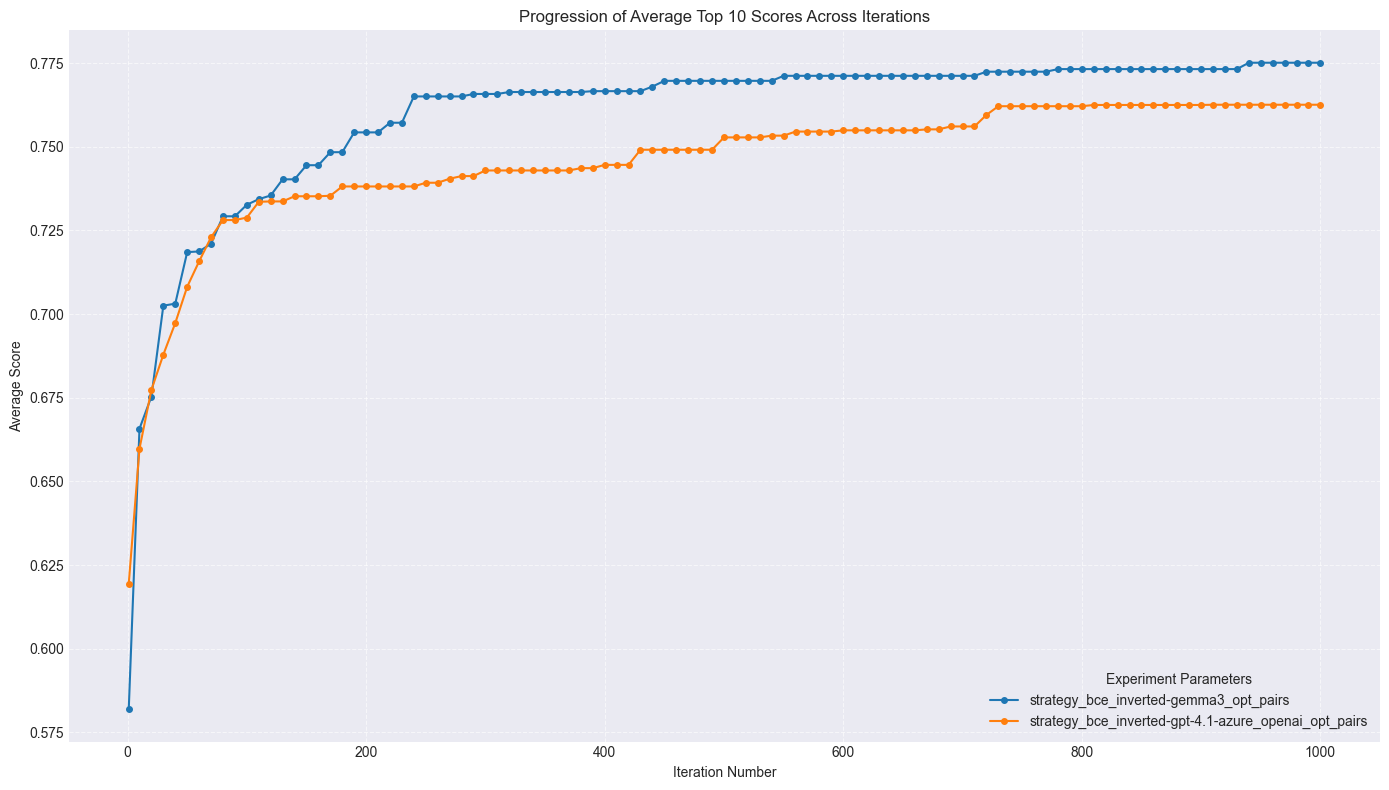

Processing file for lengths: ./experiment_results\Experiment-40-strategy_bce_inverted-gemma3_opt_pairs.txt with label: strategy_bce_inverted-gemma3_opt_pairs
Processing file for lengths: ./experiment_results\Experiment-41-strategy_bce_inverted-gpt-4.1-azure_openai_opt_pairs.txt with label: strategy_bce_inverted-gpt-4.1-azure_openai_opt_pairs


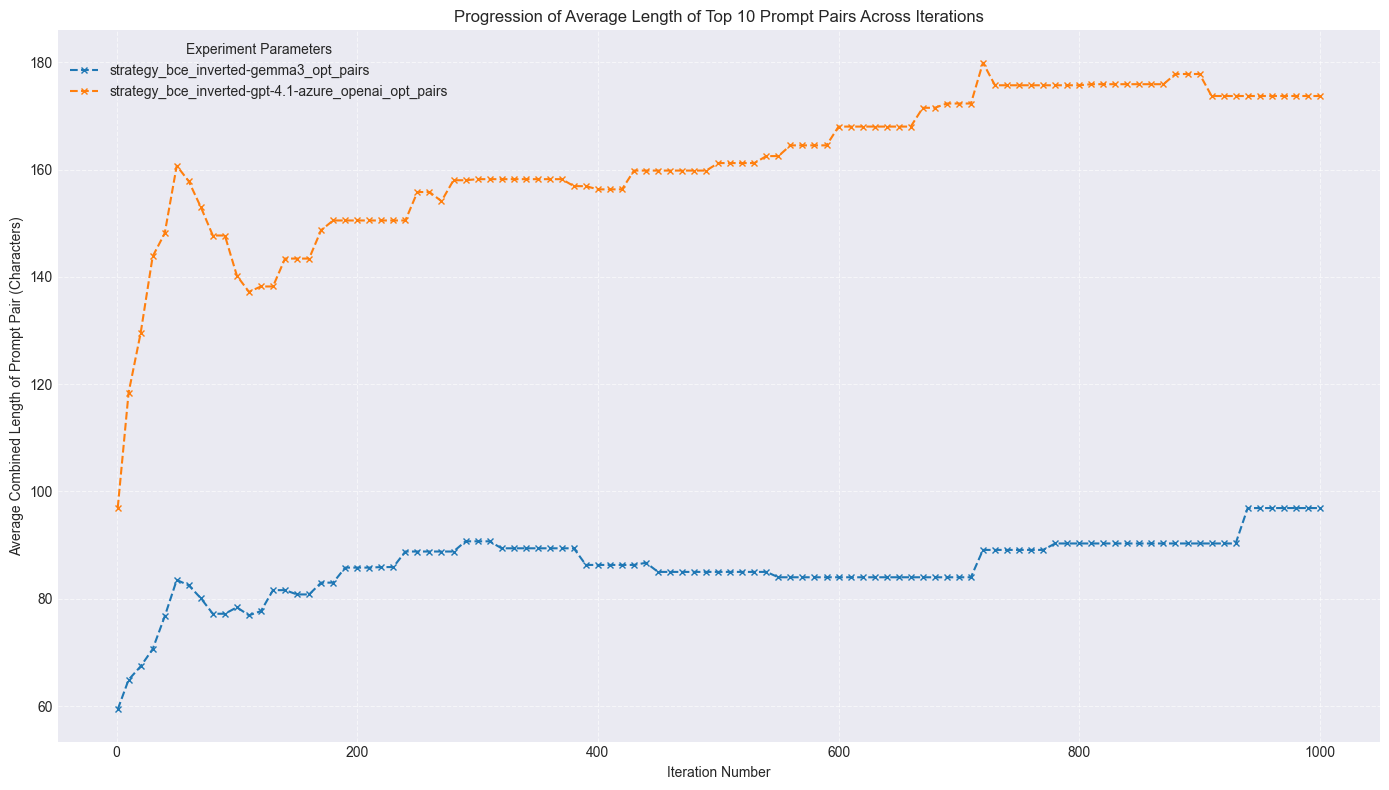

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import defaultdict

def parse_experiment_file(filepath):
    """
    Parses a single experiment file to extract scores AND description pairs for each iteration.
    Returns a dictionary where keys are iteration numbers and values are
    lists of (description_pair, score) tuples for that iteration.
    """
    iterations_data = defaultdict(list)
    current_iteration = None

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('Iteration'):
                try:
                    current_iteration = int(line.split(':')[0].split(' ')[1])
                except (ValueError, IndexError):
                    current_iteration = None # Reset if parsing fails
                continue
            
            if current_iteration is not None and line:
                # Regex to match the tuple format and score
                match = re.match(r"\('(.+?)', '(.+?)'\), Score: (\d+\.\d+)", line)
                if match:
                    # Capture both descriptions as a tuple
                    desc1 = match.group(1).strip()
                    desc2 = match.group(2).strip()
                    score = float(match.group(3))
                    iterations_data[current_iteration].append(((desc1, desc2), score))
    return iterations_data

def get_top_n_items(iteration_data, n=10):
    """
    Given data for a single iteration, returns the top N (description_pair, score) tuples.
    """
    # Sort by score in descending order and take the top N
    sorted_items = sorted(iteration_data, key=lambda x: x[1], reverse=True)
    return sorted_items[:n]

def calculate_average_pair_length(pair_list):
    """
    Calculates the average combined length of description pairs.
    Each pair is a tuple (desc1, desc2).
    """
    if not pair_list:
        return 0
    total_length = 0
    for desc1, desc2 in pair_list:
        total_length += len(desc1) + len(desc2)
    return total_length / len(pair_list)

def plot_experiment_scores(experiment_numbers, directory="./experiment_results"):
    """
    Plots the progression of average top 10 scores for given experiment numbers.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(14, 8))

    all_experiment_scores_data = {} # Stores {label: {iteration: [top_10_scores]}}

    for exp_num in experiment_numbers:
        filepath_found = None
        label = ""
        for filename in os.listdir(directory):
            if filename.startswith(f"Experiment-{exp_num}-") and filename.endswith(".txt"):
                filepath_found = os.path.join(directory, filename)
                label = filename.split(f"Experiment-{exp_num}-")[1].replace(".txt", "")
                break
        
        if not filepath_found:
            print(f"Warning: File for Experiment-{exp_num} not found. Skipping score plot.")
            continue
        
        print(f"Processing file for scores: {filepath_found} with label: {label}")
        parsed_data = parse_experiment_file(filepath_found)
        
        experiment_scores = defaultdict(list)
        for iteration, items_list in parsed_data.items():
            top_items = get_top_n_items(items_list, n=10)
            # Extract just scores for plotting this graph
            scores_only = [score for (_, score) in top_items]
            experiment_scores[iteration].extend(scores_only) 

        all_experiment_scores_data[label] = experiment_scores

    if not all_experiment_scores_data:
        print("No experiment score data found to plot.")
    else:
        for label, iter_data in all_experiment_scores_data.items():
            iterations = sorted(iter_data.keys())
            avg_scores = [sum(iter_data[it]) / len(iter_data[it]) if iter_data[it] else 0 for it in iterations]
            plt.plot(iterations, avg_scores, label=f'{label}', marker='o', markersize=4)

        plt.title('Progression of Average Top 10 Scores Across Iterations')
        plt.xlabel('Iteration Number')
        plt.ylabel('Average Score')
        plt.legend(title='Experiment Parameters')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

def plot_average_prompt_length(experiment_numbers, directory="./experiment_results"):
    """
    Plots the average length of the top 10 prompt pairs for given experiment numbers.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(14, 8))

    all_experiment_lengths_data = {} # Stores {label: {iteration: [avg_length_of_top_10_pairs]}}

    for exp_num in experiment_numbers:
        filepath_found = None
        label = ""
        for filename in os.listdir(directory):
            if filename.startswith(f"Experiment-{exp_num}-") and filename.endswith(".txt"):
                filepath_found = os.path.join(directory, filename)
                label = filename.split(f"Experiment-{exp_num}-")[1].replace(".txt", "")
                break
        
        if not filepath_found:
            print(f"Warning: File for Experiment-{exp_num} not found. Skipping length plot.")
            continue
        
        print(f"Processing file for lengths: {filepath_found} with label: {label}")
        parsed_data = parse_experiment_file(filepath_found)
        
        experiment_avg_lengths = {}
        for iteration, items_list in parsed_data.items():
            top_items = get_top_n_items(items_list, n=10)
            # Extract just the description pairs for length calculation
            description_pairs_only = [desc_pair for (desc_pair, _) in top_items]
            avg_length = calculate_average_pair_length(description_pairs_only)
            experiment_avg_lengths[iteration] = avg_length 

        all_experiment_lengths_data[label] = experiment_avg_lengths

    if not all_experiment_lengths_data:
        print("No experiment length data found to plot.")
    else:
        for label, iter_data in all_experiment_lengths_data.items():
            iterations = sorted(iter_data.keys())
            avg_lengths = [iter_data[it] for it in iterations]
            plt.plot(iterations, avg_lengths, label=f'{label}', marker='x', markersize=4, linestyle='--')

        plt.title('Progression of Average Length of Top 10 Prompt Pairs Across Iterations')
        plt.xlabel('Iteration Number')
        plt.ylabel('Average Combined Length of Prompt Pair (Characters)')
        plt.legend(title='Experiment Parameters')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


# --- Main execution ---
if __name__ == "__main__":
    # Ensure the directory exists
    output_dir = "./experiment_results"
    experiment_numbers_to_plot = [40, 41]
    # Plotting the scores
    plot_experiment_scores(experiment_numbers_to_plot, directory=output_dir)

    # Plotting the average length of prompt pairs
    plot_average_prompt_length(experiment_numbers_to_plot, directory=output_dir)